1/1 [==============================] - 0s 124ms/step
Gender: Male 
Age: 38-43 years
Gender: Male 
Age: 25-32 years
Gender: Male 
Age: 38-43 years


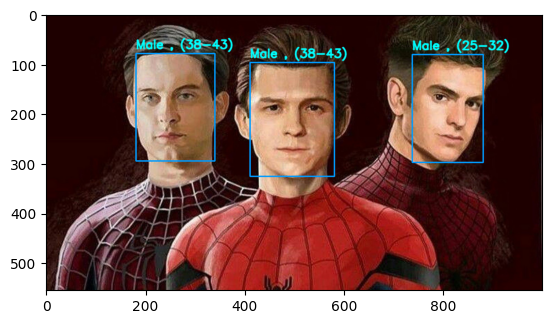

In [10]:
# Подключаем библиотеки компьютерного зрения, детектора и матплот для вывода изображения
import cv2
from mtcnn import MTCNN
import matplotlib.pyplot as plt

# Функция для определения лиц
def highlightFace(net, frame, conf_threshold=0.7):
    
    # Определяем высоту и ширину кадра
    frameHeight=frame.shape[0]
    frameWidth=frame.shape[1]
    
    # Преобразуем картинку в двоичный пиксельный объект
    blob=cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], True, False)
    
    # Устанавливаем этот объект как входной параметр для нейросети
    net.setInput(blob)
    
    # Выполняем прямой проход для распознавания лиц
    detections=net.forward()
    
    # Создаем переменную для рамок вокруг лица
    faceBoxes=[]
    
    # Создаем детектор лиц
    detector=MTCNN()
    
    # Обнаружение лиц на изображении 
    face=detector.detect_faces(frame)
    
    # Проходимся по рамкам лиц
    for i in range(len(face)): 
        
        # Обозначаем ограничивающие рамки
        bounding_box = face[i]['box']
        
        # Формируем координаты рамок
        x1=bounding_box[0]
        y1=bounding_box[1]
        x2=bounding_box[0]+bounding_box[2]
        y2=bounding_box[1]+bounding_box[3]
        
        # Добавляем координаты в общую переменную
        faceBoxes.append([x1,y1,x2,y2])
        
        # Ограничиваем область лиц на изображении
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,155,255), 2)
        
    # Вовзращаем кадр с рамками
    return frame,faceBoxes

# Загружаем веса для распознавания лиц
faceProto="opencv_face_detector.pbtxt"

# Загружаем конфигурацию нейросети — слои и связи нейронов
faceModel="opencv_face_detector_uint8.pb"

# Точно так же загружаем модели для определения пола и возраста
genderProto="gender_deploy.prototxt"
genderModel="gender_net.caffemodel"
ageProto="age_deploy.prototxt"
ageModel="age_net.caffemodel"

# Настраиваем свет
MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)

# Итоговые результаты работы нейросетей для пола и возраста
genderList=['Male ','Female']
ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']

# Запускаем нейросеть по распознаванию лиц
faceNet=cv2.dnn.readNet(faceModel,faceProto)

# Запускаем нейросети по определению пола и возраста
genderNet=cv2.dnn.readNet(genderModel,genderProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)

# ------------------------------------------------------------------------------
# -------------------------ВСТАВЛЯТЬ_ИЗОБРАЖЕНИЕ_СЮДА---------------------------
# ------------------------------------------------------------------------------

# Получаем изображение, в котором нужно определить пол и возраст
frame= cv2.cvtColor(cv2.imread('pauki.jpg'), cv2.COLOR_BGR2RGB)

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

# Определяем лица в кадре
resultImg,faceBoxes=highlightFace(faceNet,frame)

# Перебираем все найденные лица в кадре
for faceBox in faceBoxes:
    
    # Получаем изображение лица на основе рамки
    face=frame[max(0,faceBox[1]):
                min(faceBox[3],frame.shape[0]-1),max(0,faceBox[0])
                :min(faceBox[2], frame.shape[1]-1)]
    
    # Получаем на этой основе новый бинарный пиксельный объект
    blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
    
    # Отправляем его в нейросеть для определения пола
    genderNet.setInput(blob)
    
    # Получаем результат работы нейросети
    genderPreds=genderNet.forward()
    
    # Выбираем пол на основе этого результата
    gender=genderList[genderPreds[0].argmax()]
    
    # Отправляем результат в переменную с полом
    print(f'Gender: {gender}')

    # Делаем то же самое для возраста
    ageNet.setInput(blob)
    agePreds=ageNet.forward()
    age=ageList[agePreds[0].argmax()]
    print(f'Age: {age[1:-1]} years')

    # Добавляем текст возле каждой рамки в кадре
    cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)

# Показываем полученное изображение
plt.imshow(resultImg)